<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/toy_binary_classification_problem_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of a Binary Classification problem with PyTorch

## Generate data

In [1]:
import torch
import sklearn.datasets
import sklearn.model_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.13.1+cu116'

We will generate an artificial dataset using sklearn's make_circles

In [3]:
n_samples = 1000

X, y = sklearn.datasets.make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
# Features, Lables
len(X), len(y)

(1000, 1000)

In [5]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]), array([1, 1, 1, 1, 0]))

In [6]:
circles = pd.DataFrame({
    'X1': X[:, 0], 
    'X2': X[:, 1], 
    'label': y
})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


## Visualizing the data:

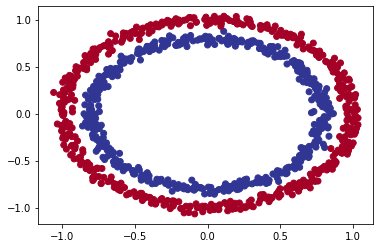

In [7]:
plt.scatter(circles['X1'], circles['X2'], c=circles['label'], cmap=plt.cm.RdYlBu)

## Turning data into Tensors

Recommendation: check input and output shapes!

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

## Splitting data

In [11]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
n_samples, len(X_train), len(y_train), len(X_test), len(y_test)

(1000, 800, 800, 200, 200)

# Building a Model

Building a Model to classify the circles. The process will be device-agnostic! The model will have a hidden layer that takes 2 features and returns a vector of 5 dimensions. To build this model we need to make sure that our model solves all these issues:

1. Model subclasses the torch.nn.Module class
2. The model fits the input and output shapes of our data
3. Model implements (and overwrites) a forward method
4. Create an instance of our model and send it to the correct device

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [14]:
class CircleModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = torch.nn.Linear(
        in_features=2,
        out_features=5
    )
    self.layer2 = torch.nn.Linear(
        in_features=5,
        out_features=1
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    output_layer1 = self.layer1(x)
    return self.layer2(output_layer1)

In [15]:
model = CircleModel()

model = model.to(device)

In [16]:
model

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model.parameters()).device

device(type='cuda', index=0)

## Simplifying the model with toch.nn.Sequential

For simple models, we can use the torch.nn.Sequential, that already implements the forward pass, and connects the layers that we pass together.

In [18]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=5), 
    torch.nn.Linear(in_features=5, out_features=1)
).to(device)

In [19]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.2632, -0.2371],
                      [ 0.4709,  0.4370],
                      [-0.2112,  0.0792],
                      [ 0.2460,  0.4006],
                      [ 0.0009, -0.0336]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3237, -0.1445,  0.5697,  0.3885,  0.3495], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0085, -0.4049, -0.1225, -0.4132,  0.2857]], device='cuda:0')),
             ('1.bias', tensor([-0.2497], device='cuda:0'))])

In [20]:
model.eval()

with torch.inference_mode():
  meaningless_preds = model(X_test.to(device))


print(len(meaningless_preds), meaningless_preds.shape)
print(len(X_test), len(X_test.shape))

200 torch.Size([200, 1])
200 2


In [21]:
meaningless_preds[:5]

tensor([[-0.4736],
        [-0.6776],
        [-0.0243],
        [-0.6006],
        [-0.1600]], device='cuda:0')

## Defining the loss function and optimizer

We are using BCEWithLogitsLoss, because it already implements the sigmoid activation function under the hood, so we don't need to implmement it ourselves. If we look at the PyTorch documentation, we will see that this solution is more stable than BCELoss alone. 

Also, if we had the BCELoss, we would need to add a sigmoid layer at the end of our model to convert the logits to probabilities.

In [22]:
loss_fn = torch.nn.BCEWithLogitsLoss()

lr = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

## Implementing the Accuracy calculation function

In [23]:
def accuracy_fn(y_true, y_pred):
  # torch.eq is torch equals, its like doing y_true == y_pred
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct * 100 / len(y_true)
  return acc

# Training the model

## Converting the outputs (logits) to probabilities

**Logits:** Are the output (raw output) of our models in the scope of Machine Learning, and more specifically, Deep Learning.

We can convert the logits to probabilities passing them through an activation function. Generally the sigmoid for binary classification and softmax for multi-class classification.

Finally, we convert them to predictions using a rounding function or the argmax() function.

In [24]:
model.eval()

with torch.inference_mode():
  y_logits = model(X_test.to(device))
  
y_logits[:5]

tensor([[-0.4736],
        [-0.6776],
        [-0.0243],
        [-0.6006],
        [-0.1600]], device='cuda:0')

Dimensions don't match as-is

In [25]:
y_logits.shape, y_test.shape

(torch.Size([200, 1]), torch.Size([200]))

We will pass the logits to prediction probabilities with the Sigmoid function.

In [26]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.3838],
        [0.3368],
        [0.4939],
        [0.3542],
        [0.4601]], device='cuda:0')

Convert the prediction probabilities to labels (0 or 1)

In [27]:
# Predicted labels
torch.round(y_pred_probs[:5])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In a single step:

In [28]:
torch.round(torch.sigmoid(y_logits))[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

## Building the Train/Test loop

In [29]:
torch.manual_seed(42)
epochs = 100

epoch_counts = []
acc_train_loss = []
acc_test_loss = []
acc_train_acc = []
acc_test_acc = []

for epoch in range(1, epochs+1):
  model.train()

  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test  = X_test.to(device), y_test.to(device)

  # Forward pass
  logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(logits))

  # Loss:
  loss = loss_fn(logits, y_train)
  train_acc = accuracy_fn(y_train, y_pred)

  # Optimizer
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Optimizer step
  optimizer.step()

  if epoch % 10 == 0:
    model.eval()

    with torch.inference_mode():
      valid_logits = model(X_test).squeeze()
      valid_loss  = loss_fn(valid_logits, y_test)
      valid_preds = torch.round(torch.sigmoid(valid_logits))
      valid_acc = accuracy_fn(y_test, valid_preds)

    print(f"Epoch: {epoch} | Train Loss: {loss.item()} | Train Acc: {train_acc:.2f}% | Test Loss: {valid_loss.item()} | Test Acc: {valid_acc:.2f}%")

    epoch_counts.append(epoch)
    acc_train_loss.append(loss.item())
    acc_test_loss.append(valid_loss.item())
    acc_train_acc.append(train_acc)
    acc_test_acc.append(valid_acc)

Epoch: 10 | Train Loss: 0.7083005309104919 | Train Acc: 47.00% | Test Loss: 0.6981213688850403 | Test Acc: 52.50%
Epoch: 20 | Train Loss: 0.703400731086731 | Train Acc: 47.50% | Test Loss: 0.69407719373703 | Test Acc: 53.50%
Epoch: 30 | Train Loss: 0.7009164094924927 | Train Acc: 47.88% | Test Loss: 0.6923506259918213 | Test Acc: 53.50%
Epoch: 40 | Train Loss: 0.6994081139564514 | Train Acc: 48.12% | Test Loss: 0.6915444731712341 | Test Acc: 52.50%
Epoch: 50 | Train Loss: 0.6983547806739807 | Train Acc: 48.50% | Test Loss: 0.6911420226097107 | Test Acc: 54.00%
Epoch: 60 | Train Loss: 0.6975517272949219 | Train Acc: 48.62% | Test Loss: 0.690938413143158 | Test Acc: 53.50%
Epoch: 70 | Train Loss: 0.6969085335731506 | Train Acc: 49.25% | Test Loss: 0.690844714641571 | Test Acc: 53.00%
Epoch: 80 | Train Loss: 0.6963791251182556 | Train Acc: 49.12% | Test Loss: 0.690818190574646 | Test Acc: 53.00%
Epoch: 90 | Train Loss: 0.6959362030029297 | Train Acc: 49.00% | Test Loss: 0.69083571434021 |

Notice that the model is getting a near 50% accuracy on both the train and test sets. This is not good, it's basically the same as selecting a random label for each prediction (or selecting the same label for all elements in the dataset).

Let's visualize why this may be:

In [30]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

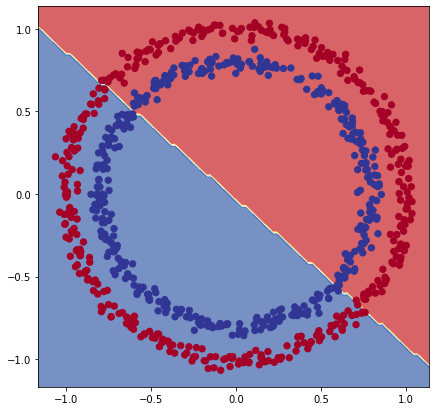

In [31]:
plt.figure(figsize=(7, 7))
plot_decision_boundary(model, X_train, y_train)

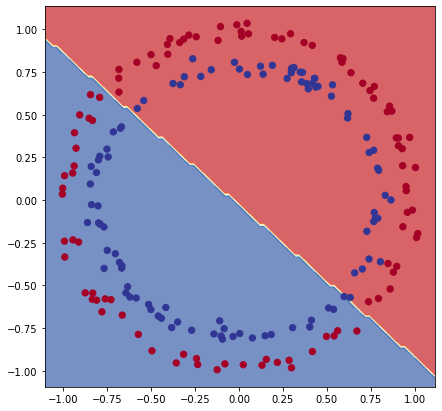

In [32]:
plt.figure(figsize=(7, 7))
plot_decision_boundary(model, X_test, y_test)

The model is **linear**! It's trying to build a liner decision boundary, but the data is circular. It's never going to work! We are trying to solve a non-linear model with a linear approach.

# How can we improve the model performance?

There are a few ways of solving this:

* Add more layers: Give the model more complexity
* Add more neurons: Give the model more complexity
* Fit for longer: Add more epochs to expose your dataset to the model for extra repetitions
* Change the activation functions (inner activation functions haven't been implemented here, for instance)
* Change the learning rate: This can normally be seen in the train/test loss plots. If the loss goes all over the place or doesn't converge, it's probably because the leaning rate is too small or too large
* Change the loss function: This determines how we measure if the predictions are correct, so maybe changing the approach changes the convergence of the model

# Re-building an improved model

In [33]:
class CircleModelV2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = torch.nn.Linear(in_features=2, out_features=10)
    self.layer2 = torch.nn.Linear(in_features=10, out_features=10)
    self.layer3 = torch.nn.Linear(in_features=10, out_features=1)

  def forward(self, x: torch.Tensor):
    output1 = self.layer1(x)
    output2 = self.layer2(output1)
    output3 = self.layer3(output2)

    return output3

In [34]:
model2 = CircleModelV2().to(device)

In [35]:
model2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
model2.state_dict()

OrderedDict([('layer1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.25

In [37]:
loss_fn = torch.nn.BCEWithLogitsLoss()

lr = 0.1
optimizer = torch.optim.SGD(params=model2.parameters(), lr=lr)

In [38]:
torch.manual_seed(42)
epochs = 1000

epoch_counts = []
acc_train_loss = []
acc_test_loss = []
acc_train_acc = []
acc_test_acc = []

for epoch in range(1, epochs+1):
  model2.train()

  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test  = X_test.to(device), y_test.to(device)

  # Forward pass
  logits = model2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(logits))

  # Loss:
  loss = loss_fn(logits, y_train)
  train_acc = accuracy_fn(y_train, y_pred)

  # Optimizer
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Optimizer step
  optimizer.step()

  if epoch % 100 == 0:
    model2.eval()

    with torch.inference_mode():
      valid_logits = model2(X_test).squeeze()
      valid_loss  = loss_fn(valid_logits, y_test)
      valid_preds = torch.round(torch.sigmoid(valid_logits))
      valid_acc = accuracy_fn(y_test, valid_preds)

    print(f"Epoch: {epoch} | Train Loss: {loss.item()} | Train Acc: {train_acc:.2f}% | Test Loss: {valid_loss.item()} | Test Acc: {valid_acc:.2f}%")

    epoch_counts.append(epoch)
    acc_train_loss.append(loss.item())
    acc_test_loss.append(valid_loss.item())
    acc_train_acc.append(train_acc)
    acc_test_acc.append(valid_acc)

Epoch: 100 | Train Loss: 0.6930495500564575 | Train Acc: 50.62% | Test Loss: 0.6937812566757202 | Test Acc: 49.00%
Epoch: 200 | Train Loss: 0.6929861307144165 | Train Acc: 51.12% | Test Loss: 0.6943693161010742 | Test Acc: 46.00%
Epoch: 300 | Train Loss: 0.6929804682731628 | Train Acc: 51.62% | Test Loss: 0.6945756077766418 | Test Acc: 45.00%
Epoch: 400 | Train Loss: 0.6929799318313599 | Train Acc: 51.12% | Test Loss: 0.6946447491645813 | Test Acc: 46.00%
Epoch: 500 | Train Loss: 0.6929798722267151 | Train Acc: 51.00% | Test Loss: 0.6946678757667542 | Test Acc: 46.00%
Epoch: 600 | Train Loss: 0.6929798722267151 | Train Acc: 51.00% | Test Loss: 0.6946755647659302 | Test Acc: 46.00%
Epoch: 700 | Train Loss: 0.6929798722267151 | Train Acc: 51.00% | Test Loss: 0.6946781873703003 | Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.6929798722267151 | Train Acc: 51.00% | Test Loss: 0.6946790814399719 | Test Acc: 46.00%
Epoch: 900 | Train Loss: 0.6929798722267151 | Train Acc: 51.00% | Test Loss: 0.6

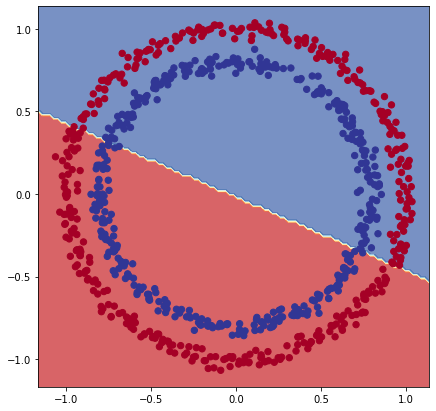

In [39]:
plt.figure(figsize=(7, 7))
plot_decision_boundary(model2, X_train, y_train)

## Why is the model still not learning?

The model is still learning a straight line as the decision boundary. This should be enough of a clue! The model with added complexity is still solving a linear problem! There is no way our neural network will be able to capture the circular behavior of our dataset with this format.

In order to solve this, we need to implement a non-linear function, known as an activation function. These functions introduce non-linearities that allow the neural network to "curve" to adapt to the dataset. We can find more about the approximation power of activation functions in these two papers:
* [Approximation Capabilities of Muitilayer
Feedforward Networks](https://web.njit.edu/~usman/courses/cs677_spring21/hornik-nn-1991.pdf)
* [On Approximation Capabilities of ReLU Activation
and Softmax Output Layer in Neural Networks](https://arxiv.org/pdf/2002.04060.pdf)

A good way to check if this will solve the issue or not is by taking this to the tensorflow playground [here](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.83377&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

# Final Model with non-linearities

In [40]:
class CircleModelV3(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(in_features=2, out_features=10),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=10, out_features=10),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=10, out_features=1)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

In [44]:
model3 = CircleModelV3().to(device)
model3

CircleModelV3(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [45]:
loss_fn = torch.nn.BCEWithLogitsLoss()

lr = 0.1
optimizer = torch.optim.SGD(params=model3.parameters(), lr=lr)

In [46]:
torch.manual_seed(42)
epochs = 1200

epoch_counts = []
acc_train_loss = []
acc_test_loss = []
acc_train_acc = []
acc_test_acc = []

for epoch in range(1, epochs+1):
  model3.train()

  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test  = X_test.to(device), y_test.to(device)

  # Forward pass
  logits = model3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(logits))

  # Loss:
  loss = loss_fn(logits, y_train)
  train_acc = accuracy_fn(y_train, y_pred)

  # Optimizer
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Optimizer step
  optimizer.step()

  if epoch % 100 == 0:
    model3.eval()

    with torch.inference_mode():
      valid_logits = model3(X_test).squeeze()
      valid_loss  = loss_fn(valid_logits, y_test)
      valid_preds = torch.round(torch.sigmoid(valid_logits))
      valid_acc = accuracy_fn(y_test, valid_preds)

    print(f"Epoch: {epoch} | Train Loss: {loss.item()} | Train Acc: {train_acc:.2f}% | Test Loss: {valid_loss.item()} | Test Acc: {valid_acc:.2f}%")

    epoch_counts.append(epoch)
    acc_train_loss.append(loss.item())
    acc_test_loss.append(valid_loss.item())
    acc_train_acc.append(train_acc)
    acc_test_acc.append(valid_acc)

Epoch: 100 | Train Loss: 0.6911655068397522 | Train Acc: 53.00% | Test Loss: 0.6910386681556702 | Test Acc: 52.50%
Epoch: 200 | Train Loss: 0.689789891242981 | Train Acc: 53.38% | Test Loss: 0.6894145607948303 | Test Acc: 55.00%
Epoch: 300 | Train Loss: 0.6879706382751465 | Train Acc: 53.00% | Test Loss: 0.687256395816803 | Test Acc: 56.00%
Epoch: 400 | Train Loss: 0.6852025985717773 | Train Acc: 52.75% | Test Loss: 0.6841528415679932 | Test Acc: 56.50%
Epoch: 500 | Train Loss: 0.6810717582702637 | Train Acc: 52.75% | Test Loss: 0.6794673800468445 | Test Acc: 56.50%
Epoch: 600 | Train Loss: 0.675218939781189 | Train Acc: 54.38% | Test Loss: 0.6729280948638916 | Test Acc: 56.00%
Epoch: 700 | Train Loss: 0.6666958332061768 | Train Acc: 58.38% | Test Loss: 0.6633349657058716 | Test Acc: 59.00%
Epoch: 800 | Train Loss: 0.6517890095710754 | Train Acc: 64.00% | Test Loss: 0.6477615237236023 | Test Acc: 67.50%
Epoch: 900 | Train Loss: 0.6240091323852539 | Train Acc: 74.00% | Test Loss: 0.6217

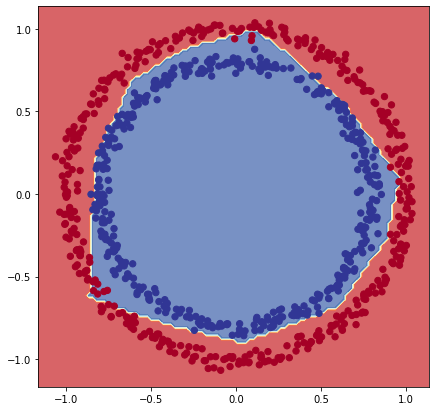

In [47]:
plt.figure(figsize=(7, 7))
plot_decision_boundary(model3, X_train, y_train)

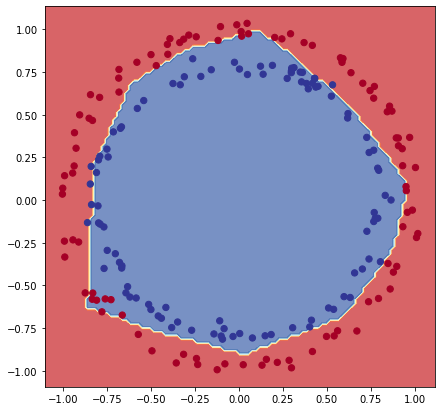

In [48]:
plt.figure(figsize=(7, 7))
plot_decision_boundary(model3, X_test, y_test)